# Visión Computacional basada en IA (Computer Vision)

## Clase 6: Detección de objetos

### 1. Configuración del ambiente

A continuación vamos a montar la unidad de Google Drive, como siempre, y dejar lista la ruta de acceso a los datos con los que vamos a trabajar.

In [ ]:
import torch
from google.colab import drive
from os import makedirs
from torchvision import transforms

!pip install wget

# montamos la unidad de Google Drive
drive.mount('/content/gdrive/')

# creamos la carpeta donde vamos a guardar los datos
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/DUIA/Computer Vision/'
makedirs(datasets_folder, exist_ok=True)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### 2. Detección de objetos con Faster R-CNN

Para ejemplificar el proceso de detección de objetos con redes neuronales en PyTorch, usaremos la arquitectura [Faster R-CNN](https://towardsdatascience.com/faster-r-cnn-for-object-detection-a-technical-summary-474c5b857b46), una de las opciones (junto a [YOLO](https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006)) más útiles para trabajar este tipo de problemas.

[Faster R-CNN](https://arxiv.org/abs/1506.01497) es una mejora respecto a [Fast R-CNN](https://towardsdatascience.com/fast-r-cnn-for-object-detection-a-technical-summary-a0ff94faa022) y, por ende, de la [R-CNN](https://towardsdatascience.com/r-cnn-for-object-detection-a-technical-summary-9e7bfa8a557c) original, que utiliza una red backbone (en este caso, una ResNet de 50 capas) para, dada una imagen, extraer un feature map que la describe. A ese mapa se le aplica en paralelo una red adicional, la Region Proposal Net, que extrae una serie de potenciales bounding box en torno a objetos que se visualizan en la imagen. Para que las propuestas sean relativamente coherentes con el contenido de la imagen, durante el entrenamiento esta red recibe penalizaciones vía una loss de regresión de la bounding box (que penaliza que las propuestas no se parezcan a las disponibles en los datos de entrenamiento) y otra de clasificación. Por otro lado, una operación de ROI Pooling detecta las cajas correctas a partir de la propuesta, y les asigna a cada una la clase que le corresponde al objeto detectado.

![](https://www.researchgate.net/profile/Vysakh_Mohan2/publication/330822827/figure/fig1/AS:727572925145090@1550478311441/This-image-shows-the-Faster-RCNN-Pipeline-Initial-layers-are-convolutional-layers-of.png)

Entrenar este engendro es una locura, así que vamos a usar la red ya preentrenada, disponible en ```torchvision```. Se usaron para ello los datos de [COCO](https://cocodataset.org/#home), "Common Objects in Context", que incluye montones de categorías.

A continuación vamos a crear una instancia de la red y a armar una lista con los nombres de las clases.

In [ ]:
import torchvision

# bajamos la red preentrenada
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
print(model)

# inicializamos la lista de nombres de las clases
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)


A continuación vamos a implementar una función que nos permita predecir las bounding boxes a partir de una imagen de entrada dada, utilizando la instancia del modelo que acabamos de crear. 

Para esto definiremos una función predict, que reciba los siguientes parámetros:
* ```image```: que es la imagen como objeto ```Image``` del paquete ```PIL``` o como un arreglo de NumPy.
* ```model```: el modelo que vamos a aplicar sobre los datos recibidos.
* ```device```: el dispositivo que vamos a usar para procesar los datos (CPU o GPU).
* ```detection_threshold```: un umbral de probabilidad mínimo que hay que alcanzar para determinar si un objeto realmente está presente en la imagen o no.

Un detalle importante acerca del modelo que acabamos de crear es que no requiere que definamos por fuera ninguna transformación de normalización, ya que la usa internamente. Por ende, solamente necesitaríamos convertir cualquier imagen a tensor para poder procesarla con la red.

In [ ]:
import torchvision.transforms as transforms

def predict(image, model, device, detection_threshold):
  '''
  Dada una imagen y un modelo, predecimos los bounding boxes y las etiquetas
  '''
  
  # transformamos la imagen a tensor y la pasamos al dispositivo
  transform = transforms.ToTensor()
  image = transform(image).to(device)
  # agregamos la dimensión para simular el tamaño del batch
  image = image.unsqueeze(0) 
  # no vamos a usar gradientes, porque estamos evaluando
  model.eval()
  with torch.no_grad():
    # aplicamos el modelo sobre la imagen
    outputs = model(image) 
  
  # recuperamos los nombres de las clases que detectamos
  pred_classes = np.asarray([coco_names[i] for i in outputs[0]['labels'].cpu().numpy()])
  # recuperamos los scores asignados por la red para cada clase
  pred_scores = outputs[0]['scores'].cpu().numpy()
  # recuperamos las coordenadas de la bounding box de cada objeto
  pred_bboxes = outputs[0]['boxes'].cpu().numpy()
  # nos quedamos solamente con las cajas que cumplan con el score mínimo
  # (no filtramos el resto porque las cajas vienen ordenadas por score)
  boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
  return boxes, pred_classes, outputs[0]['labels'].cpu().numpy(), pred_scores

Ahora solamente nos faltaría crear una función capaz de graficar las cajas, así podemos interpretar realmente los resultados de la red. Para ello, escribiremos una función ```draw_boxes``` que, dada las cajas detectadas (```boxes```), las clases (```classes```), las etiquetas asignadas por la red (```labels```) y la imagen de entrada (```image```).

In [ ]:
import torchvision.transforms as transforms
import cv2
import numpy
import numpy as np

# obtenemos colores diferentes para cada una de las clases
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

def draw_boxes(boxes, classes, labels, image, scores=None):
  # pasamos la imagen de entrada a OpenCV
  image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
  # por cada una de las cajas detectadas:
  for i, box in enumerate(boxes):
    # recuperamos el color asociado a la clase de esta caja
    color = COLORS[labels[i]]
    # graficamos el rectángulo a partir de las coordenadas de la caja
    cv2.rectangle(
        image,
        (int(box[0]), int(box[1])),
        (int(box[2]), int(box[3])),
        color, 2
    )
    # colocamos el nombre de la clase sobre el rectángulo
    if scores is None:
      cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                  cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                  lineType=cv2.LINE_AA)
    else:
      cv2.putText(image, classes[i] + ': {:.4f}'.format(scores[i]), (int(box[0]), int(box[1]-5)),
                  cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                  lineType=cv2.LINE_AA)
  return image

Y listo! Ya podemos correr nuestra red sobre la imagen de Pomelo, para ver qué encontramos en ella.

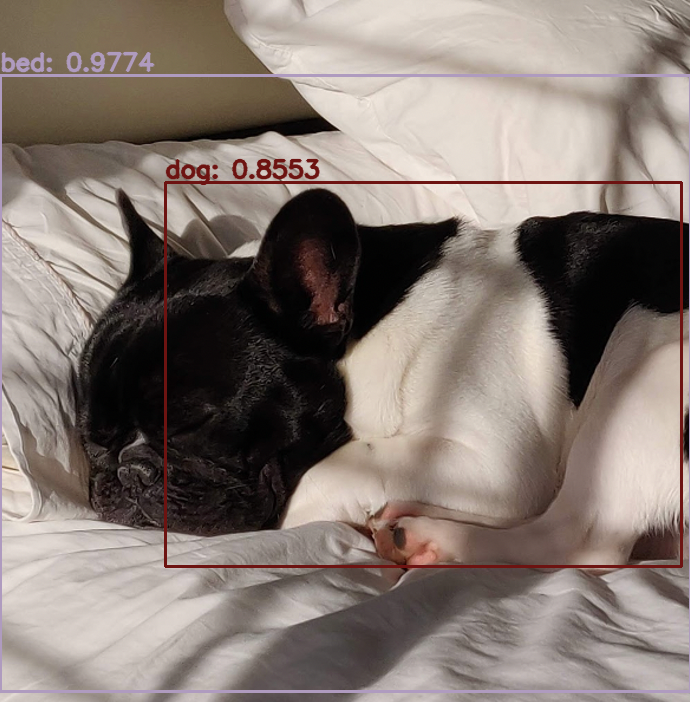

In [ ]:
import torch
from google.colab.patches import cv2_imshow
from PIL import Image
from os import path

# recuperamos el dispositivo disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# abrimos la imagen
image = Image.open(path.join(datasets_folder, 'dog.png'))
image = image.convert('RGB')
# pasamos la red en modelo evaluación y lo mandamos al dispositivo
model.eval().to(device)

# hacemos la predicción
boxes, classes, labels, scores = predict(image, model, device, 0.85)

# mostramos las cajas
image = draw_boxes(boxes, classes, labels, image, scores)
cv2_imshow(image)

Vemos que la red fue capaz de detectar que Pomelo está durmiendo arriba de la cama, y que es un perro. Sin embargo, a la zona de la cara la detecta como un gato. Esto puede tener múltiples causas, pero me la juego por una: los perros en los datos de entrenamiento probablemente no aparezcan demasiado sobre una cama, y los gatos sí.

### 3. Una aplicación de detección de objetos: detección de objetos en video

Vamos a hacer un ejercicio práctico en el que intentaremos aplicar lo que vimos recién de detección de objetos para un problema concreto. En este caso, nos interesa poder detectar objetos en los frames de un video.

Para ello, vamos a primero instalar las librerías de Python PyTube3 (que nos permite descargar videos de YouTube) y PyAV (que la necesita torchvision para trabajar con video). Después de correr las instrucciones de abajo, necesitamos volver a cargar todo el entorno de ejecución.

In [ ]:
!pip install git+https://github.com/nficano/pytube
#!pip install av
!pip install av --no-binary av

  Cloning https://github.com/nficano/pytube to /tmp/pip-req-build-bm_p9t78
  Running command git clone -q https://github.com/nficano/pytube /tmp/pip-req-build-bm_p9t78
  Created wheel for pytube: filename=pytube-9.7.0-cp36-none-any.whl size=39341 sha256=3ddac849087be981692c48928e054a225b98314672f23d9eaa760846a98c2160
  Stored in directory: /tmp/pip-ephem-wheel-cache-kgy8y80q/wheels/44/da/40/3b5e03abe33a91895343814fb44b309512375408f4a909555b
Successfully built pytube


Lo próximo que haremos será descargar [un video de YouTube](https://youtu.be/3FXUw98rrUY). En este caso, se trata de una captura obtenida con una cámara fija en la que se observa cómo pasan unos transeuntes.

In [ ]:
from pytube import YouTube

# creamos la ruta donde vamos a guardar el archivo de video
video_filename = path.join(datasets_folder, 'video.mp4')

# creamos un objeto a partir de la URL
yt = YouTube("https://youtu.be/3FXUw98rrUY")
# descargamos el video
stream = yt.streams.filter(file_extension='mp4').first()
stream.download(datasets_folder, filename='video')

'/content/gdrive/My Drive/Colab Notebooks/DUIA/2020/Computer Vision/video.mp4'

Ahora que tenemos el video descargado, podemos levantarlo a memoria utilizando la instrucción ```read_video``` que nos provee el paquete ```io``` (input/output) de ```torchvision```.

Simplemente necesitamos indicar la ruta de acceso al video que queremos cargar (```video_filename``` en este caso) y el parámetro ```pts_unit```, que indica de qué manera se quieren levantar los frames. 

In [ ]:
from torchvision.io import read_video

vframes, _, info = read_video(filename=video_filename, start_pts=0, pts_unit='sec')
print(vframes.size())

torch.Size([1091, 360, 640, 3])


Se puede ver que PyTorch nos cargó el video como un tensor, donde en la primera coordenada tenemos cada uno de los frames, luego tenemos el alto/ancho, y finalmente los colores.

Como queremos procesar nuestro video usando la red neuronal para detección de objetos, vamos a acomodar estos datos de manera tal que en los colores queden en la 2da coordenada, como PyTorch necesita.

In [ ]:
# intercambiamos la dimensión 3 por la 2
vframes_reshaped = vframes.permute(0,3,1,2)
# verificamos si el tamaño está bien
print(vframes_reshaped.size())

torch.Size([1091, 3, 360, 640])


Podríamos además chequear si lo que nos quedó realmente contiene frames:

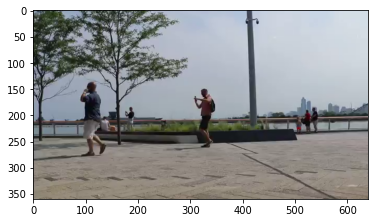

In [ ]:
import matplotlib.pyplot as plt

# imprimimos el primer frame (pasándolo a numpy para poder verlo)
plt.imshow(vframes[0,:,:,:].numpy())
plt.show()

También podemos testear qué tan bien nuestra red neuronal es capaz de procesar este primer frame que acabamos de visualizar:

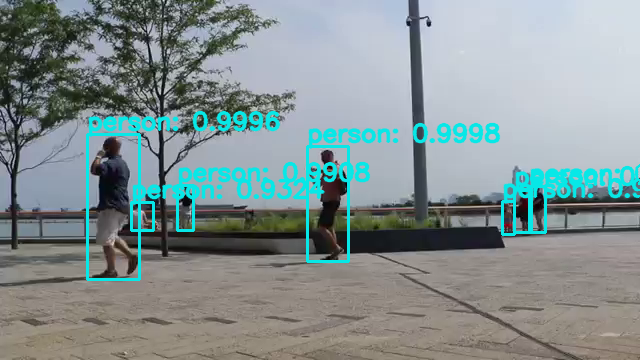

In [ ]:
# usamos el método predict (así que tenemos que pasar los frames a numpy)
boxes, classes, labels, scores = predict(vframes[0,:,:,:].numpy(), model, device, 0.8)
# dibujamos las cajas sobre la imagen
image = draw_boxes(boxes, classes, labels, vframes[0,:,:,:].numpy(), scores)
# la graficamos
cv2_imshow(image)

Se puede ver con claridad que la red es capaz de detectar a todas las personas visibles en este primer frame. Lo que podemos hacer ahora es procesar cada uno de los frames, y crear un nuevo video en donde veamos indicadas a las personas.

In [ ]:
# inicializamos un tensor con iguales dimensiones que los frames del video original
output_video = torch.zeros(vframes.size())

# indicamos la cantidad de frames que vamos a procesar
frames_to_process = int(vframes_reshaped.size()[0])
# por cada uno de los frames
for i in range(frames_to_process):
  # aviso cuál estoy procesando
  if (i % 10) == 0:
    print('Processing frame {}/{}'.format(i+1, frames_to_process))
  # obtengo la predicción
  boxes, classes, labels, scores = predict(vframes[i,:,:,:].numpy(), model, device, 0.8)
  # dibujo las cajas
  image = draw_boxes(boxes, classes, labels, vframes[i,:,:,:].numpy())
  # agrego el frame a mi tensor
  image_as_tensor = torch.from_numpy(image)
  output_video[i, :] = image_as_tensor

Processing frame 1/1091
Processing frame 11/1091
Processing frame 21/1091
Processing frame 31/1091
Processing frame 41/1091
Processing frame 51/1091
Processing frame 61/1091
Processing frame 71/1091
Processing frame 81/1091
Processing frame 91/1091
Processing frame 101/1091
Processing frame 111/1091
Processing frame 121/1091
Processing frame 131/1091
Processing frame 141/1091
Processing frame 151/1091
Processing frame 161/1091
Processing frame 171/1091
Processing frame 181/1091
Processing frame 191/1091
Processing frame 201/1091
Processing frame 211/1091
Processing frame 221/1091
Processing frame 231/1091
Processing frame 241/1091
Processing frame 251/1091
Processing frame 261/1091
Processing frame 271/1091
Processing frame 281/1091
Processing frame 291/1091
Processing frame 301/1091
Processing frame 311/1091
Processing frame 321/1091
Processing frame 331/1091
Processing frame 341/1091
Processing frame 351/1091
Processing frame 361/1091
Processing frame 371/1091
Processing frame 381/10

Listo! Tenemos todo el video procesado. Vamos a ver qué se generó. Para ello primero vamos a guardar el video usando la instrucción ```write_video``` de ```torchvision```:

In [ ]:
from torchvision.io import write_video

# guardamos el video
write_video(path.join(datasets_folder, 'processed_video.mp4'), output_video, fps=info['video_fps'])

Y con el archivo generado, podemos reproducirlo en el navegador:

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(path.join(datasets_folder, 'processed_video.mp4'),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 playbackRate=0.1 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)